In [1]:
from pyspark.sql import SparkSession
spark = (SparkSession.builder.appName("cs544")
         .master("spark://main:7077")
         .config("spark.executor.memory", "512M")
         .config("spark.sql.warehouse.dir", "hdfs://main:9000/user/hive/warehouse")
         .enableHiveSupport()
         .getOrCreate())

import os
import pandas as pd
from matplotlib import pyplot as plt
from pyspark.sql.functions import col, expr, row_number
from pyspark.sql.window import Window
import time
import requests

pd.set_option('display.max_columns', None)

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/03/31 20:10:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Downloading the Data

In [2]:
!wget https://pages.cs.wisc.edu/~harter/cs639/data/hdma-wi-2021.zip
!wget https://pages.cs.wisc.edu/~harter/cs639/data/arid2017_to_lei_xref_csv.zip
!wget https://pages.cs.wisc.edu/~harter/cs639/data/code_sheets.zip
!unzip hdma-wi-2021.zip 
!unzip arid2017_to_lei_xref_csv.zip
!unzip code_sheets.zip
!rm hdma-wi-2021.zip 
!rm arid2017_to_lei_xref_csv.zip
!rm code_sheets.zip

--2023-03-31 20:10:20--  https://pages.cs.wisc.edu/~harter/cs639/data/hdma-wi-2021.zip
Resolving pages.cs.wisc.edu (pages.cs.wisc.edu)... 128.105.7.9
Connecting to pages.cs.wisc.edu (pages.cs.wisc.edu)|128.105.7.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21494278 (20M) [application/zip]
Saving to: ‘hdma-wi-2021.zip’

hdma-wi-2021.zip    100%[===================>]  20.50M  52.5MB/s    in 0.4s    

2023-03-31 20:10:20 (52.5 MB/s) - ‘hdma-wi-2021.zip’ saved [21494278/21494278]

--2023-03-31 20:10:20--  https://pages.cs.wisc.edu/~harter/cs639/data/arid2017_to_lei_xref_csv.zip
Resolving pages.cs.wisc.edu (pages.cs.wisc.edu)... 128.105.7.9
Connecting to pages.cs.wisc.edu (pages.cs.wisc.edu)|128.105.7.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 144804 (141K) [application/zip]
Saving to: ‘arid2017_to_lei_xref_csv.zip’

arid2017_to_lei_xre 100%[===================>] 141.41K  --.-KB/s    in 0.07s   

2023-03-31 20:10:21 (1.87 MB/s)

## Uploading Data to HDFS

In [3]:
for file in os.listdir():
    if file.endswith(".csv"):
        !hdfs dfs -cp {file} hdfs://main:9000/{file}
        
!hdfs dfs -du -h hdfs://main:9000/

328      984      hdfs://main:9000/action_taken.csv
317      951      hdfs://main:9000/agency.csv
521.0 K  1.5 M    hdfs://main:9000/arid2017_to_lei_xref_csv.csv
311.6 K  934.8 K  hdfs://main:9000/counties.csv
237      711      hdfs://main:9000/denial_reason.csv
109      327      hdfs://main:9000/edit_status.csv
180      540      hdfs://main:9000/ethnicity.csv
166.8 M  500.5 M  hdfs://main:9000/hdma-wi-2021.csv
41       123      hdfs://main:9000/hoepa.csv
114      342      hdfs://main:9000/lien_status.csv
65       195      hdfs://main:9000/loan_purpose.csv
79       237      hdfs://main:9000/loan_type.csv
129.6 K  388.7 K  hdfs://main:9000/msamd.csv
122      366      hdfs://main:9000/owner_occupancy.csv
92       276      hdfs://main:9000/preapproval.csv
127      381      hdfs://main:9000/property_type.csv
387      1.1 K    hdfs://main:9000/purchaser_type.csv
252      756      hdfs://main:9000/race.csv
144      432      hdfs://main:9000/sex.csv
955      2.8 K    hdfs://main:9000/states.c

In [4]:
code_sheets = ["ethnicity", "race", "sex", "states", "counties", "tracts", 
               "action_taken", "denial_reason", "loan_type", "loan_purpose", 
                 "preapproval", "property_type"]

for filename in code_sheets:
    (spark.read.format("csv")
        .option("header", True)
        .option("inferSchema", True)
        .load(f"hdfs://main:9000/{filename}.csv").createOrReplaceTempView(f"{filename}"))
    
## Banks
(spark.read.format("csv")
        .option("header", True)
        .option("inferSchema", True)
        .load("hdfs://main:9000/arid2017_to_lei_xref_csv.csv")
        .write.saveAsTable("banks", mode="overwrite"))
 
(spark.read.format("csv")
        .option("header", True)
        .option("inferSchema", True)
        .load("hdfs://main:9000/hdma-wi-2021.csv")
        .write.bucketBy(8, "county_code").saveAsTable("loans", mode="overwrite"))

23/03/31 20:12:08 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
23/03/31 20:12:08 WARN HiveConf: HiveConf of name hive.stats.retries.wait does not exist
23/03/31 20:12:13 WARN ObjectStore: Version information not found in metastore. hive.metastore.schema.verification is not enabled so recording the schema version 2.3.0
23/03/31 20:12:13 WARN ObjectStore: setMetaStoreSchemaVersion called but recording version is disabled: version = 2.3.0, comment = Set by MetaStore UNKNOWN@172.19.0.3
23/03/31 20:12:14 WARN ObjectStore: Failed to get database global_temp, returning NoSuchObjectException
23/03/31 20:12:14 WARN HadoopFSUtils: The directory hdfs://main:9000/user/hive/warehouse/banks was not found. Was it deleted very recently?
23/03/31 20:12:15 WARN FileUtils: File does not exist: hdfs://main:9000/user/hive/warehouse/banks; Force to delete it.
23/03/31 20:12:15 ERROR FileUtils: Failed to delete hdfs://main:9000/user/hive/warehouse/banks
23/03/31 20:12:19 WARN Sessio

## Q1: what tables are in our warehouse?

In [5]:
spark.sql("SHOW TABLES").show()

+---------+-------------+-----------+
|namespace|    tableName|isTemporary|
+---------+-------------+-----------+
|  default|        banks|      false|
|  default|        loans|      false|
|         | action_taken|       true|
|         |     counties|       true|
|         |denial_reason|       true|
|         |    ethnicity|       true|
|         | loan_purpose|       true|
|         |    loan_type|       true|
|         |  preapproval|       true|
|         |property_type|       true|
|         |         race|       true|
|         |          sex|       true|
|         |       states|       true|
|         |       tracts|       true|
+---------+-------------+-----------+



## Q2: how many banks contain the word "first" in their name? Which ones contain "second"?

In [6]:
spark.sql("""
SELECT COUNT(*) as `Number of Banks Containing First`
FROM banks
WHERE LOWER(respondent_name) LIKE "%first%"
""").toPandas()

,Number of Banks Containing First
0,525


In [7]:
spark.sql("""
SELECT *
FROM banks
WHERE LOWER(respondent_name) LIKE "%second%"
""").toPandas()

,respondent_name,arid_2017,lei_2018,lei_2019,lei_2020
0,Old Second National Bank,14596,B94HV8SXGDD3J5XESU08,B94HV8SXGDD3J5XESU08,B94HV8SXGDD3J5XESU08


## Q3: how many loan applications has your "favorite" bank received in the dataset?

In [8]:
### CHOICE OF FAVOURITE BANK
spark.sql("""
SELECT * 
from banks
WHERE LOWER(respondent_name) LIKE '%chase%'
""").toPandas()

,respondent_name,arid_2017,lei_2018,lei_2019,lei_2020
0,"JPMorgan Chase Bank, National Association",9852218,7H6GLXDRUGQFU57RNE97,7H6GLXDRUGQFU57RNE97,7H6GLXDRUGQFU57RNE97


In [9]:
results = spark.sql("""
SELECT COUNT(*) as `Number of Chase Loan Applications`
from loans
INNER JOIN banks on loans.lei = banks.lei_2020
WHERE respondent_name = "JPMorgan Chase Bank, National Association"
""")

results.toPandas()

,Number of Chase Loan Applications
0,8178


## Q4: what does results.explain("formatted") tell us about Spark's query plan for Q3?

In [10]:
results.explain("formatted")

== Physical Plan ==
AdaptiveSparkPlan (25)
+- == Final Plan ==
   * HashAggregate (15)
   +- ShuffleQueryStage (14)
      +- Exchange (13)
         +- * HashAggregate (12)
            +- * Project (11)
               +- * BroadcastHashJoin Inner BuildRight (10)
                  :- * Filter (3)
                  :  +- * ColumnarToRow (2)
                  :     +- Scan parquet default.loans (1)
                  +- BroadcastQueryStage (9)
                     +- BroadcastExchange (8)
                        +- * Project (7)
                           +- * Filter (6)
                              +- * ColumnarToRow (5)
                                 +- Scan parquet default.banks (4)
+- == Initial Plan ==
   HashAggregate (24)
   +- Exchange (23)
      +- HashAggregate (22)
         +- Project (21)
            +- BroadcastHashJoin Inner BuildRight (20)
               :- Filter (16)
               :  +- Scan parquet default.loans (1)
               +- BroadcastExchange (19)
            

### which table is sent to every executor via a BroadcastExchange operation?
lei_2020 is sent to every executor via a BroadcastExchange operation

### on which tables is "is not null" filtering added by the optimizer?
"is not null" filtering is applied to both the loans and banks tables as an INNER JOIN was executed

### does the plan involve HashAggregates (depending on how you write the query, it may or may not)? If so, which ones?
HashAggregates are involved in the plan. The HashAggregates compute 2 partial counts and 2 normal counts.

## Q5: what are the top 10 biggest loans (in terms of loan_amount) that were approved by your favorite bank?

In [11]:
spark.sql("""
SELECT CONCAT(STATE, lpad(COUNTY, 3, "0")) as county_unique_id, * 
from (
    SELECT *, row_number() OVER (PARTITION BY STATE, COUNTY, NAME ORDER BY AREA DESC) AS num
    from counties
    )
WHERE num = 1
""").createOrReplaceTempView("county_mod")

spark.sql("""
SELECT census_tract, NAME as county, loan_purpose.loan_purpose, derived_dwelling_category, loan_amount/1000 as thousands, 
interest_rate, loan_term / 12 as years, action_taken.action_taken
from loans
INNER JOIN banks on loans.lei = banks.lei_2020
LEFT JOIN action_taken on loans.action_taken = action_taken.id 
LEFT JOIN county_mod on loans.county_code = county_mod.county_unique_id
LEFT JOIN loan_purpose on loans.loan_purpose = loan_purpose.id
WHERE respondent_name = "JPMorgan Chase Bank, National Association"
AND action_taken.action_taken = "Loan originated"
ORDER BY loan_amount DESC
LIMIT 10
""").toPandas()

,census_tract,county,loan_purpose,derived_dwelling_category,thousands,interest_rate,years,action_taken
0,55133203500,Waukesha,None,Single Family (1-4 Units):Site-Built,12915.0,2.75,30.0,Loan originated
1,55059000100,Kenosha,None,Multifamily:Site-Built,4975.0,3.38,30.0,Loan originated
2,55079012800,Milwaukee,None,Multifamily:Site-Built,4605.0,3.36,30.0,Loan originated
3,55127001602,Walworth,None,Single Family (1-4 Units):Site-Built,4555.0,2.75,30.0,Loan originated
4,55079185400,Milwaukee,None,Multifamily:Site-Built,3625.0,4.94,20.5,Loan originated
5,55127001602,Walworth,Home purchase,Single Family (1-4 Units):Site-Built,3535.0,2.875,30.0,Loan originated
6,55133204100,Waukesha,None,Single Family (1-4 Units):Site-Built,3305.0,2.625,30.0,Loan originated
7,55079019400,Milwaukee,None,Multifamily:Site-Built,3105.0,3.48,25.0,Loan originated
8,55127001602,Walworth,None,Single Family (1-4 Units):Site-Built,3005.0,3.125,30.0,Loan originated
9,55133203500,Waukesha,Home purchase,Single Family (1-4 Units):Site-Built,3005.0,2.25,30.0,Loan originated


## Q6: when computing a MEAN aggregate per group of loans, under what situation (when) do we require network I/O between the partial_mean and mean operations?

In [12]:
spark.sql("""
SELECT AVG(loan_amount)
from loans
GROUP BY county_code
""").explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[county_code#973], functions=[avg(loan_amount#990)])
   +- HashAggregate(keys=[county_code#973], functions=[partial_avg(loan_amount#990)])
      +- FileScan parquet default.loans[county_code#973,loan_amount#990] Batched: true, DataFilters: [], Format: Parquet, Location: InMemoryFileIndex(1 paths)[hdfs://main:9000/user/hive/warehouse/loans], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<county_code:string,loan_amount:double>, SelectedBucketsCount: 8 out of 8




In [13]:
spark.sql("""
SELECT AVG(loan_amount)
from loans
GROUP BY lei
""").explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[lei#970], functions=[avg(loan_amount#990)])
   +- Exchange hashpartitioning(lei#970, 200), ENSURE_REQUIREMENTS, [plan_id=1141]
      +- HashAggregate(keys=[lei#970], functions=[partial_avg(loan_amount#990)])
         +- FileScan parquet default.loans[lei#970,loan_amount#990] Batched: true, DataFilters: [], Format: Parquet, Location: InMemoryFileIndex(1 paths)[hdfs://main:9000/user/hive/warehouse/loans], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<lei:string,loan_amount:double>




When a GROUP BY on lei is executed, we can see from the output of .explain() that there is an additional line stating "Exchange hashpartitioning(lei#1986, 200), ENSURE_REQUIREMENTS, [plan_id=1877]". Since the dataset is not partitioned / bucketed by LEI, a network shuffle is required in the GROUP BY process. On the other hand, since the dataset is bucketed on county_code, a network I/O shuffle does not occur when we perform a GROUP BY on county_code.

The network I/O is required when the GROUP BY acts on a non-bucketed column, such as LEI, because different machines/partitions may contain the same value within that column.

## Q7: what are the average interest rates for Wells Fargo applications for the ten counties where Wells Fargo receives the most applications?

In [14]:
df = spark.sql("""
SELECT NAME as County, AVG(interest_rate) as `InterestRate`, COUNT(*) as `NumApplications`
from loans
INNER JOIN banks on banks.lei_2020 = loans.lei
LEFT JOIN county_mod on loans.county_code = county_mod.county_unique_id
WHERE respondent_name LIKE "%Wells Fargo Bank, National Association%"
GROUP BY NAME
ORDER BY COUNT(*) DESC
LIMIT 10
""").toPandas()

Text(0, 0.5, 'Average Interest Rate')

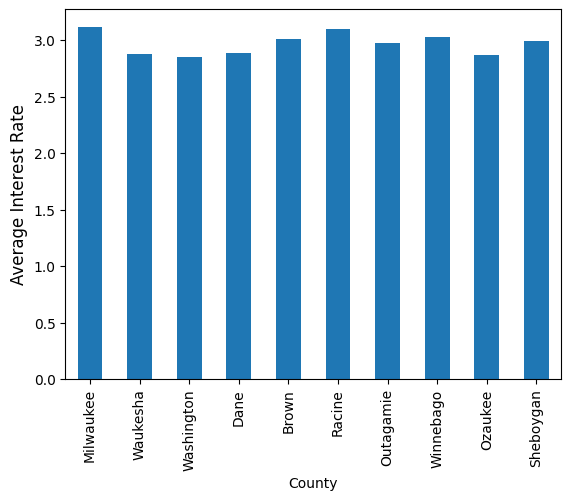

In [15]:
fig, ax = plt.subplots()
df.plot.bar(x="County", y="InterestRate", ax=ax)
ax.legend().remove()
ax.set_ylabel("Average Interest Rate", size=12)

## Q8: what is the second biggest loan application amount in each county? (answer for top 10 counties).

In [16]:
df_q8 = spark.sql("""
SELECT CountyName, loan_amount/1000000 as loan, row_number() OVER (PARTITION BY CountyName ORDER BY loan_amount DESC) AS num
from 
    (
        SELECT NAME as CountyName, loan_amount
        from loans
        LEFT JOIN county_mod on loans.county_code = county_mod.county_unique_id
    )
WHERE CountyName IS NOT NULL
ORDER BY loan_amount DESC
""").where("num == 2").limit(10).toPandas()

Text(0.5, 0, 'County')

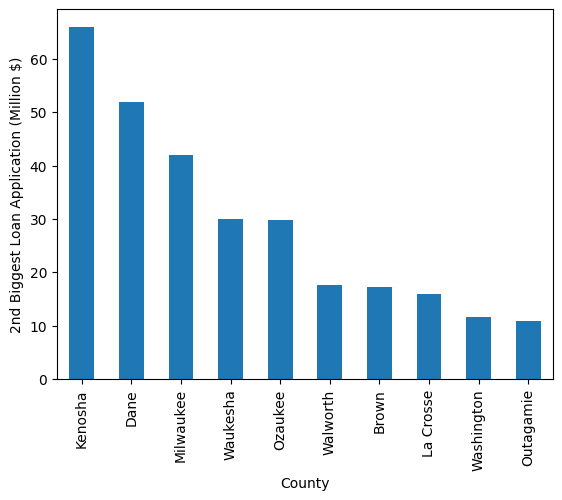

In [17]:
fig, ax = plt.subplots()
df_q8.plot.bar(x="CountyName", y="loan", ax=ax)
ax.legend().remove()
ax.set_ylabel("2nd Biggest Loan Application (Million $)", size=10)
ax.set_xlabel("County", size=10)

## Q9: what is the cost of caching and the impact on subsequent queries?

In [18]:
df = spark.sql("""
    SELECT interest_rate
    FROM banks
    INNER JOIN loans
    ON banks.lei_2020 = loans.lei 
    WHERE banks.respondent_name = 'Wells Fargo Bank, National Association'
    """)
times = []
df.unpersist()
for i in range(10):
    if i == 4:
        df.cache()
    start = time.time()
    df.count()
    times.append((time.time() - start)*1000)

Text(0, 0.5, 'Run Time (Milliseconds)')

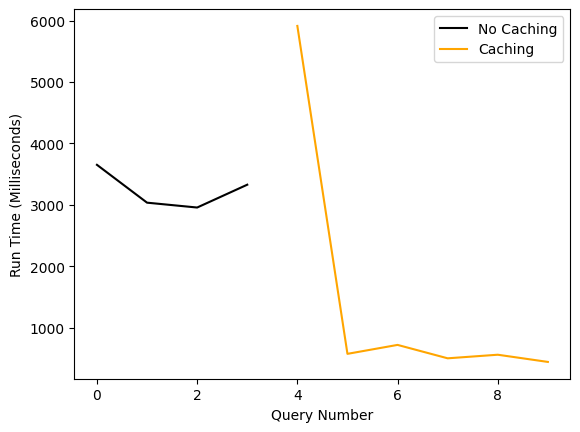

In [19]:
fig, ax = plt.subplots()
ax.plot(range(4), times[:4], c='black', label='No Caching')
ax.plot(range(4,10), times[4:10], c='orange', label='Caching')
ax.legend()
ax.set_xlabel("Query Number")
ax.set_ylabel("Run Time (Milliseconds)")

## Q10: what is the impact of caching a single partition on load balance?

In [20]:
r = requests.get("http://localhost:4040/api/v1/applications")
r.raise_for_status()
appID = r.json()[0]['id']

df2 = df.repartition(1)
df2.cache()

worker_1 = []
worker_2 = [] 
for i in range(10):
    df2.count()
    r2 = requests.get("http://localhost:4040/api/v1/applications/{}/executors".format(appID))
    w1 = r2.json()[1]['completedTasks']
    w2 = r2.json()[2]['completedTasks']
    worker_1.append(w1)
    worker_2.append(w2)

Text(0, 0.5, 'Completed Tasks')

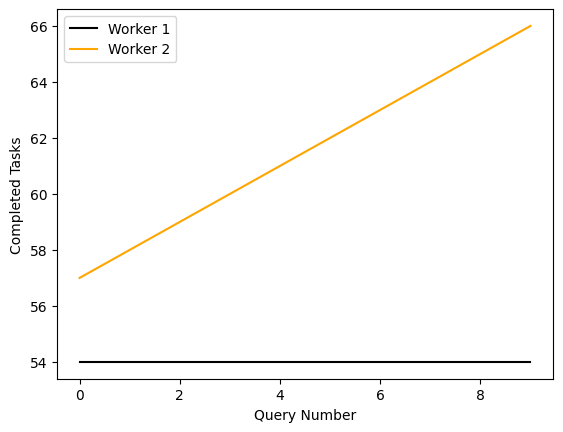

In [21]:
fig, ax = plt.subplots()
ax.plot(range(10), worker_1, c='black', label='Worker 1')
ax.plot(range(10), worker_2, c='orange', label='Worker 2')
ax.legend()
ax.set_xlabel("Query Number")
ax.set_ylabel("Completed Tasks")